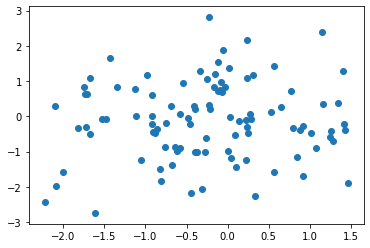

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import uuid
from sortedcontainers import SortedList

points = np.random.randn(100, 2)
plt.scatter(points[:, 0], points[:, 1])
data = [(str(uuid.uuid4()), p) for p in points]

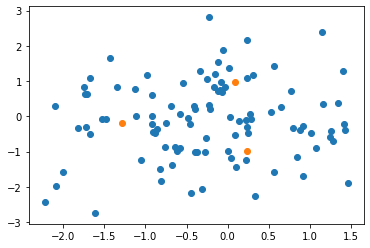

In [2]:
class KMeans:
    
    def __init__(self, k=3, tol=1e-4, max_iter=300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
        
    def fit(self, data):
        self.centroids = {}
        
        np.random.shuffle(data)
        for i in range(self.k):
            self.centroids[i] = data[i]
        
        for i in range(self.max_iter):
            self.classifications = {}
            for j in range(self.k):
                self.classifications[j] = []
                
            for d in data:
                distances = [np.linalg.norm(d-self.centroids[c]) for c in self.centroids]
                classification = np.argmin(distances)
                self.classifications[classification].append(d)
            
            prev_centroids = dict(self.centroids)
            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification], axis=0)
            ok = True
            for c in self.centroids:
                prev = prev_centroids[c]
                cur = self.centroids[c]
                if np.sum((prev-cur) / prev * 100.0) > self.tol:
                    ok = False
                    break
            if ok:
                break
                
a = KMeans(k=3)
a.fit(points)

centroids = np.array([val for val in a.centroids.values()])

plt.scatter(points[:, 0], points[:, 1])
plt.scatter(centroids[:, 0], centroids[:, 1])

In [3]:
# data should look like this
# {uid of the point: corrdinate in d-dimension}

class TKM:
    
    def __init__(self, k=3, tol=1e-4, max_iter=300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
    
    def compute_threshold(self, data, point):
        pass
    
    def fit(self, data):
        self.d = {}
        self.d_prime = {}
        self.centers = {}
        self.classifications = {}
        self.m = {}
        self.SUM = {}
        self.sigma = 0
        
        # Initialize centroids (or centers)
#         np.random.shuffle(data)
        for i in range(self.k):
            self.centers[i] = data[i][1]
            self.m[data[i][0]] = i
            self.classifications[i] = []
            
        for p in data:
            distances = [np.linalg.norm(p[1]-self.centers[c]) for c in self.centers]
            classification = np.argmin(distances)
            self.classifications[classification].append(p)
            self.m[p[0]] = classification
            
        # Initialize d and d_prime
        for p in data:
            self.d[p[0]] = np.linalg.norm(p[1]-self.centers[self.m[p[0]]])
            cur_min = None
            for c in self.centers:
                if c==self.m[p[0]]:
                    continue
                if cur_min==None:
                    cur_min = np.linalg.norm(p[1]-self.centers[c])
                else:
                    cur_min = min(cur_min, np.linalg.norm(p[1]-self.centers[c]))
            self.d_prime[p[0]] = cur_min
            
        # Initialize P_active
        ## H is a binary search tree of tuple (d-d', uid)
        self.H = SortedList([(self.d_prime[p[0]]-self.d[p[0]], p[1], p[0]) for p in data], key=lambda x:x[0])
        self.P_active = list(self.H.islice(0, self.H.bisect_left((0, None, None))))
        
        # Initialize SUM
        for c in self.centers:
            self.SUM[c] = np.vstack([k[1] for k in self.classifications[c]]).sum(axis=0)   
            
        # Main loop
        ok = False
        for i in range(self.max_iter):
            ok = True
            for p in self.P_active:
                distances = [np.linalg.norm(p[1]-self.centers[c]) for c in self.centers]
                nearest = np.argmin(distances)
                if nearest != self.m[p[2]]:
                    self.SUM[self.m[p[2]]] = np.subtract(self.SUM[self.m[p[2]]], p[1])
                    self.SUM[nearest] = np.add(self.SUM[nearest], p[1])
                    self.m[p[2]] = nearest
            for c in self.centers:
                m_g = self.SUM[c]/len(self.classifications[c])
                self.sigma = max(self.sigma, np.linalg.norm(self.centers[c]-m_g))
                if np.sum((self.centers[c]-m_g)/self.centers[c] * 100.0) > self.tol:
                    ok = False
                self.centers[c] = m_g
            if ok:
                break
            self.P_active = list(self.H.islice(0, self.H.bisect_left((self.sigma, None, None))))

In [4]:
model = TKM(k=3)
model.fit(data)

[]
ok


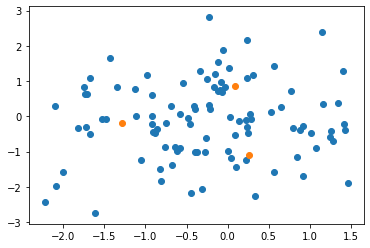

In [5]:
model.centers
centers = np.array([val for val in model.centers.values()])
plt.scatter(points[:, 0], points[:, 1])
plt.scatter(centers[:, 0], centers[:, 1])